**Create an AlexNet-like architecture CNN model.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=1)

        self.conv5 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=1)


        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(2048, 512)
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(128, 32)
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):

        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.fc4(x)
        return x

model = CNN()

**Check total parameters**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters in the model: {total_params}")

Total trainable parameters in the model: 1414785


**Load the data.**

**Perform resizing and data augmentation.**

**Due to resource constraints, I'll use only 250 * 250 pixels of input.**


**Utilize only rotation augmentation, as X-ray data typically have good quality due to the collection process involving individuals with medical expertise such as nurses or doctors.**

**Create a data loader.**


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import os


train_transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.RandomApply([transforms.RandomRotation(degrees=(-3, 3))], p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

test_transform = transforms.Compose([
    transforms.Resize((250, 250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])


path_train = '/content/drive/MyDrive/For Python/chest_xray_2/train'
path_test = '/content/drive/MyDrive/For Python/chest_xray_2/test'


train_dataset = datasets.ImageFolder(os.path.join(path_train), transform=train_transform)
train_loader = DataLoader(dataset = train_dataset, batch_size = 128, shuffle = True)

test_dataset = datasets.ImageFolder(os.path.join(path_test), transform=test_transform)
test_loader = DataLoader(dataset = test_dataset, batch_size = 128, shuffle = True)

In [ ]:
y_check = []
for batch_index, (X, y) in enumerate(train_loader):
  y_check.extend(y)

In [ ]:
sum(y_check) / len(y_check) * 100

tensor(74.2906)

Have 74.2906% on class 1 (Pneumonia), 25.7094% on class 0 (Normal)


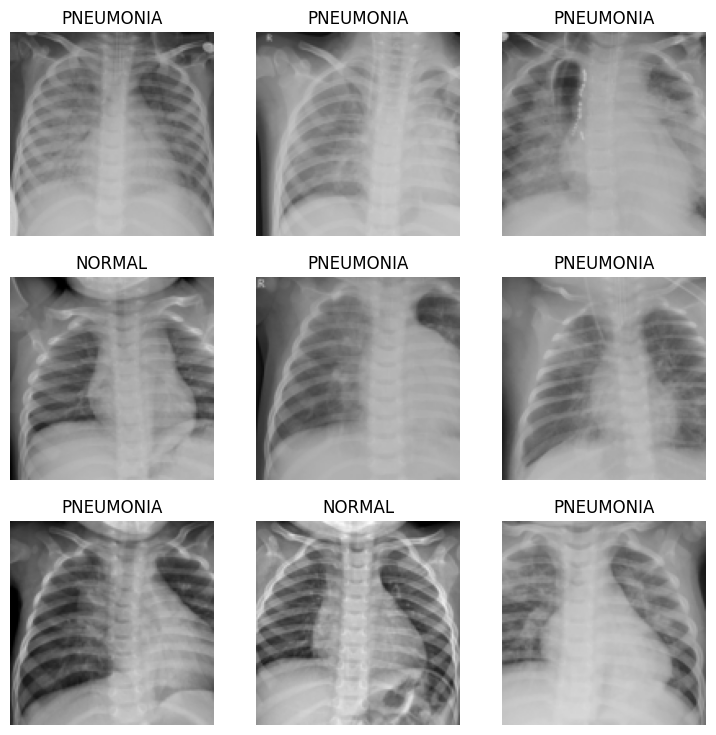

In [ ]:
from fastai.vision.all import *


dls = ImageDataLoaders.from_folder(path_train, valid_pct=0.1, item_tfms=Resize(250), shuffle =True)
dls.show_batch()

**Train AlexNet-like arhitecture model.**

**Computing class weight to solve the class imbalance problem.**

In [ ]:
import torch.optim as optim

class_weights = torch.tensor(0.346)

criterion_alex = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer_alex = optim.Adam(model.parameters())

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):

  for batch_index, (X_train, y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(X_train)
    loss = criterion_alex(y_pred.float(), y_train.float().unsqueeze(1))

    optimizer_alex.zero_grad()

    loss.backward()

    optimizer_alex.step()

    if batch_index % 20 == 0:
      print(f'Epoch: {epoch + 1}/{num_epochs}, Batch: {batch_index}, Loss: {loss:.4f}')

Epoch: 1/10, Batch: 0, Loss: 0.3634
Epoch: 1/10, Batch: 20, Loss: 0.1548
Epoch: 1/10, Batch: 40, Loss: 0.2690
Epoch: 2/10, Batch: 0, Loss: 0.1182
Epoch: 2/10, Batch: 20, Loss: 0.1666
Epoch: 2/10, Batch: 40, Loss: 0.2043
Epoch: 3/10, Batch: 0, Loss: 0.1256
Epoch: 3/10, Batch: 20, Loss: 0.0570
Epoch: 3/10, Batch: 40, Loss: 0.0705
Epoch: 4/10, Batch: 0, Loss: 0.0946
Epoch: 4/10, Batch: 20, Loss: 0.0444
Epoch: 4/10, Batch: 40, Loss: 0.0781
Epoch: 5/10, Batch: 0, Loss: 0.0415
Epoch: 5/10, Batch: 20, Loss: 0.0398
Epoch: 5/10, Batch: 40, Loss: 0.0684
Epoch: 6/10, Batch: 0, Loss: 0.0627
Epoch: 6/10, Batch: 20, Loss: 0.0262
Epoch: 6/10, Batch: 40, Loss: 0.0077
Epoch: 7/10, Batch: 0, Loss: 0.0452
Epoch: 7/10, Batch: 20, Loss: 0.0252
Epoch: 7/10, Batch: 40, Loss: 0.0682
Epoch: 8/10, Batch: 0, Loss: 0.0378
Epoch: 8/10, Batch: 20, Loss: 0.0103
Epoch: 8/10, Batch: 40, Loss: 0.0357
Epoch: 9/10, Batch: 0, Loss: 0.0123
Epoch: 9/10, Batch: 20, Loss: 0.0190
Epoch: 9/10, Batch: 40, Loss: 0.0457
Epoch: 10/

**Cumpute accuracy, recall, precision, f1-score.**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

model.eval()
with torch.inference_mode():

  alex_y_pred = []
  alex_y_test = []

  for batch_index, (X_test, y_test) in enumerate(test_loader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    y_val = model(X_test)

    predicted = ((torch.sigmoid(y_val) >= 0.5) * 1)

    alex_y_test.extend(list(y_test.numpy()))
    alex_y_pred.extend(list(predicted.numpy()))

acc = accuracy_score(alex_y_test, alex_y_pred)
precision = precision_score(alex_y_test, alex_y_pred)
recall = recall_score(alex_y_test, alex_y_pred)
f1_score = f1_score(alex_y_test, alex_y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

Accuracy: 0.8606
Precision: 0.8272
Recall: 0.9821
F1-score: 0.8980


**Import pre-trained EfficientNetv2 model ,I'll use the s size.**

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

eff_netv2 = torchvision.models.efficientnet_v2_s(weights=EfficientNet_V2_S_Weights)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 136MB/s]


In [ ]:
print(eff_netv2)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

**Check the parameters.**

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(eff_netv2)
print(f"Total trainable parameters in the model: {total_params}")

Total trainable parameters in the model: 20178769


**Adjust the last classifier layer to have output of 1 for classification task.**

In [ ]:
eff_netv2.classifier[1] = nn.Linear(1280,1)

In [ ]:
print(eff_netv2.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

class_weights = torch.tensor(0.346)

criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(eff_netv2.parameters())

**Train the EfficientNetv2 model.**

In [ ]:
num_epochs = 5

model.train()
for epoch in range(num_epochs):

  for batch_index, (X_train, y_train) in enumerate(train_loader):

    X_train = X_train.to(device)
    y_train = y_train.to(device)

    y_pred = eff_netv2(X_train)
    loss = criterion(y_pred.float(), y_train.float().unsqueeze(1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    if batch_index % 10 == 0:
      print(f'Epoch: {epoch + 1}/{num_epochs}, Batch: {batch_index}, Loss: {loss:.4f}')

Epoch: 1/5, Batch: 0, Loss: 0.3434
Epoch: 1/5, Batch: 10, Loss: 0.0495
Epoch: 1/5, Batch: 20, Loss: 0.0356
Epoch: 1/5, Batch: 30, Loss: 0.0179
Epoch: 1/5, Batch: 40, Loss: 0.0340
Epoch: 2/5, Batch: 0, Loss: 0.0241
Epoch: 2/5, Batch: 10, Loss: 0.0488
Epoch: 2/5, Batch: 20, Loss: 0.0176
Epoch: 2/5, Batch: 30, Loss: 0.0077
Epoch: 2/5, Batch: 40, Loss: 0.0071
Epoch: 3/5, Batch: 0, Loss: 0.0099
Epoch: 3/5, Batch: 10, Loss: 0.0206
Epoch: 3/5, Batch: 20, Loss: 0.0236
Epoch: 3/5, Batch: 30, Loss: 0.0069
Epoch: 3/5, Batch: 40, Loss: 0.0371
Epoch: 4/5, Batch: 0, Loss: 0.0053
Epoch: 4/5, Batch: 10, Loss: 0.0252
Epoch: 4/5, Batch: 20, Loss: 0.0027
Epoch: 4/5, Batch: 30, Loss: 0.0014
Epoch: 4/5, Batch: 40, Loss: 0.0231
Epoch: 5/5, Batch: 0, Loss: 0.0069
Epoch: 5/5, Batch: 10, Loss: 0.0203
Epoch: 5/5, Batch: 20, Loss: 0.0073
Epoch: 5/5, Batch: 30, Loss: 0.0189
Epoch: 5/5, Batch: 40, Loss: 0.0066


In [ ]:
torch.save(eff_netv2.state_dict(), 'eff_netv2.pth')

**Compute the accuracy, recall, precision, f1-score of the model.**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


model.eval()
with torch.inference_mode():

  eff_y_pred = []
  eff_y_test = []

  for batch_index, (X_test, y_test) in enumerate(test_loader):

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    y_val = eff_netv2(X_test)

    predicted = (torch.sigmoid(y_val) >= 0.5) * 1

    eff_y_test.extend(list(y_test.numpy()))
    eff_y_pred.extend(list(predicted.numpy()))

acc = accuracy_score(eff_y_test, eff_y_pred)
precision = precision_score(eff_y_test, eff_y_pred)
recall = recall_score(eff_y_test, eff_y_pred)
f1_score = f1_score(eff_y_test, eff_y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

Accuracy: 0.8846
Precision: 0.8487
Recall: 0.9923
F1-score: 0.9149


**Ensemble both model**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score


model.eval()
with torch.inference_mode():


  alex_eff_y_test = []
  alex_eff_y_pred = []

  for batch_index, (X_test, y_test) in enumerate(test_loader):
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    y_val_eff = eff_netv2(X_test)
    y_val_alex = model(X_test)

    concatenated = torch.cat([y_val_eff.to(float), y_val_alex.to(float)], axis=1)
    result = torch.mean(concatenated, axis=1)

    all_predicted = ((result >= 0.5) * 1)

    alex_eff_y_test.extend(list(y_test.numpy()))
    alex_eff_y_pred.extend(list(all_predicted.numpy()))

acc = accuracy_score(alex_eff_y_test, alex_eff_y_pred)
precision = precision_score(alex_eff_y_test, alex_eff_y_pred)
recall = recall_score(alex_eff_y_test, alex_eff_y_pred)
f1_score = f1_score(alex_eff_y_test, alex_eff_y_pred)

print(f'Accuracy: {acc:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1_score:.4f}')

Accuracy: 0.8878
Precision: 0.8604
Recall: 0.9795
F1-score: 0.9161


**Result**

**AlexNet-like ======= EfficientNetV2 ======= Ensemble by Averaging**

**Accuracy: 0.8606  <<<<< 0.8846 <<<<<<<<<<<<<< 0.8878**

**Precision: 0.8272  <<<<< 0.8487 <<<<<<<<<<<<<< 0.8604**

**Recall: 0.9821 <<<<<<< 0.9923 >>>>>>>>>>>>>>  0.9795**

**F1-score: 0.8980 <<<<<< 0.9149 <<<<<<<<<<<<<< 0.9161**

**EfficientNetV2 outperforms in recall metrics, while ensembles outperform in accuracy, precision, and F1-score. Therefore, the choice depends on whether you prioritize recall or precision.**